In [1]:
using Plots
using TensorCrossInterpolation, LinearAlgebra
using QuanticsTCI
using QuanticsGrids
using ITensorMPS
using ITensors
using NDTensors
using TCIITensorConversion
using IterativeSolvers
using LinearMaps
using LinearAlgebra
include("src/differential_mpo.jl")

get_c_vec (generic function with 1 method)

In [2]:
# simulation parameter, starting conditions and boundaries
R = 10
max_bond = 10
a = 0.1
dx = 1 / (2^R-1)
delta_t = 0.1 * 2.0^-(R-1)
nu = 1e-5
penalty_coefficient = 2.5e5

function u_1(x, y)
    return exp(-((((x - 0.5)/a)^2/2) + (((y - 0.5)/a)^2)/2))
end

function u_2(x, y)
    return exp(-((((x - 0.5)/a)^2/2) + (((y - 0.5)/a)^2)/2))
end

# QuanticsTCI
qgrid = DiscretizedGrid{2}(R, (0,0), (1,1); includeendpoint = true)
u1q, ranks1, errors1 = quanticscrossinterpolate(Float64, u_1, qgrid; maxbonddim=max_bond)
u2q, ranks2, errors2 = quanticscrossinterpolate(Float64, u_2, qgrid; maxbonddim=max_bond)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 10, DiscretizedGrid{2}(10, (0.0, 0.0), (1.0, 1.0), 2, :fused, true), TensorCrossInterpolation.CachedFunction{Float64, BitIntegers.UInt256} with 21055 entries), [15, 15, 15], [0.041509875322360175, 0.041509875322360175, 0.038063661899463364])

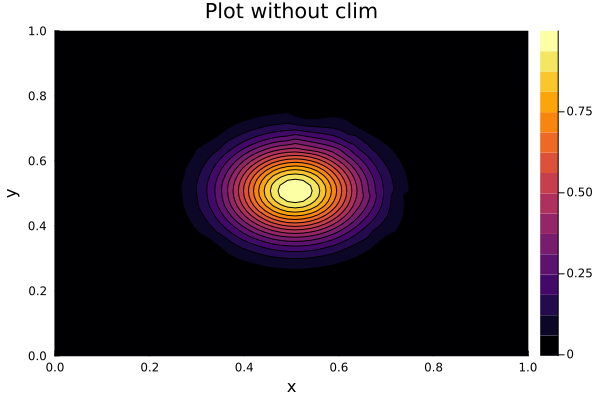

In [3]:
# Convert to ITensorMPS
s = siteinds("Qudit", R, dim=4)
u = deepcopy([ITensorMPS.MPS(TensorTrain(u1q.tci), sites=s), ITensorMPS.MPS(TensorTrain(u2q.tci), sites=s)])
v = deepcopy(u)

# Base MPO's
d1x = Diff_1_8_x(dx, s)
d1y = Diff_1_8_y(dx, s)
d2x = Diff_2_8_x(dx, s)
d2y = Diff_2_8_y(dx, s)
dx_dy = apply(d1x, d1y, maxdim=max_bond, cutoff=1e-30)
del = MPO([delta(s[i], s[i]', s[i]'') for i in 1:length(s)])

plot_mps(u[1], R, 6)

In [4]:
center = 3
u = orthogonalize.(u, center)
v = orthogonalize.(v, center)
t = 0

0

In [ ]:
function precontract_mpo_mps(mps_out, mpo, mps_in, center)

    result_l = ITensor(1.0)
    result_r = ITensor(1.0)

    for i in 1:center-1
        result_l *= mpo[i] * dag(mps_out[i])' * mps_in[i]
    end

    for i in length(s):-1:center+1
        result_r *= mpo[i] * dag(mps_out[i])' * mps_in[i]
    end

    return mpo[center] * result_l * result_r
end

precontract_mpo_mps (generic function with 1 method)

In [27]:
v1_d2x_v1, inds_in = precontract_mpo_mps(v[1], d2x, v[1], center)
println("Done!")

Done!


In [30]:
c = zeros(4*10*10)
c_core = ITensor(c, inds_in)

ITensor ord=3 (dim=4|id=480|"Qudit,Site,n=3") (dim=10|id=721|"l=2,link") (dim=10|id=191|"l=3,link")
Dense{Float64, Vector{Float64}}

In [65]:
function A_function(c_vec)
    return c_vec - penalty_coefficient * delta_t^2 * apply_H(c_vec, v, d1, center, max_bond)
end
d = sum(length.(array.(getindex.(v, center))))
A = FunctionMap{Float64,false}(A_function, d)

128×128 FunctionMap{Float64,false}(A_function; issymmetric=false, ishermitian=false, isposdef=false)

In [66]:
history = cg!(c_vec, A, beta, abstol=1e-3, reltol=0, verbose=true, maxiter=100, log=true)[2]
println("Center $center: $history")
place_c_vec!(v, c_vec, center)

  1	3.81e+00
  2	7.14e-01
  3	1.31e+00
  4	1.00e+00
  5	1.14e+00
  6	1.95e+00
  7	2.39e+00
  8	1.65e+00
  9	1.44e+00
 10	4.24e+00
 11	6.95e+00
 12	5.40e+00
 13	2.26e+00
 14	1.73e+00
 15	1.13e+01
 16	5.98e+01
 17	2.24e+02
 18	6.05e+02
 19	1.24e+03
 20	1.98e+03
 21	2.49e+03
 22	2.48e+03
 23	1.96e+03
 24	1.22e+03
 25	5.92e+02
 26	2.16e+02
 27	5.92e+01
 28	1.06e+01
 29	7.60e+00
 30	1.03e+01
 31	1.47e+02
 32	2.06e+03
 33	2.90e+04
 34	4.03e+05
 35	5.56e+06
 36	7.58e+07
 37	1.02e+09
 38	1.37e+10
 39	1.81e+11
 40	2.38e+12
 41	3.16e+13
 42	6.53e+14
 43	2.31e+15
 44	2.93e+15
 45	2.00e+15
 46	1.16e+15
 47	5.16e+14
 48	6.74e+13
 49	9.61e+12
 50	1.43e+12
 51	2.13e+11
 52	3.17e+10
 53	4.74e+09
 54	7.11e+08
 55	1.07e+08
 56	1.61e+07
 57	2.44e+06
 58	3.70e+05
 59	5.64e+04
 60	8.61e+03
 61	1.32e+03
 62	2.07e+02
 63	3.85e+01
 64	1.90e+01
 65	2.89e+01
 66	6.94e+01
 67	1.75e+02
 68	4.35e+02
 69	1.06e+03
 70	2.54e+03
 71	6.02e+03
 72	1.41e+04
 73	3.24e+04
 74	7.40e+04
 75	1.67e+05
 76	3.71e+05
 77	8.18e+05

ITensor ord=3 (dim=4|id=532|"Qudit,Site,n=2") (dim=4|id=604|"l=2,link") (dim=4|id=782|"l=1,link")
Dense{Float64, Vector{Float64}}

In [13]:
function optimize_V(v, a, b, del_t, log=false)
    success = true
    for center in length(v[1]):-1:1
        
        # orthogonalize mps's
        v = orthogonalize.(v, center)
        a = orthogonalize.(a, center)
        b = orthogonalize.(b, center)

        # starting guess for cg
        c_vec = get_c_vec(v, center)

        # rhs of equation
        beta = make_beta(v, a, b, center, delta_t, nu, d1, d2, del, max_bond)

        # linear operator
        function A_function(c_vec)
            return c_vec - penalty_coefficient * delta_t^2 * apply_H(c_vec, v, d1, center, max_bond)
        end
        d = sum(length.(array.(getindex.(v, center))))
        A = FunctionMap{Float64,false}(A_function, d)

        # solve system
        if log
            history = cg!(c_vec, A, beta, abstol=1e-6, reltol=0, verbose=false, maxiter=100, log=log)[2]
            println("Center $center: $history")
        else
            cg!(c_vec, A, beta, abstol=1e-3, reltol=0, verbose=false, maxiter=100)
        end

        if norm(A(c_vec) - beta) > 1e-2
            println("Fail!")
            success = false
            break
        end

        # place solution back in the mps
        place_c_vec!(v, c_vec, center)
    end
    return v, success
end

optimize_V (generic function with 2 methods)

In [ ]:
U1, success1 = optimize_V(u, u/4, u, delta_t/6, true)
U2, success2 = optimize_V(u, u/4, 3*U1 + u/4, delta_t/3, true)
U3, success3 = optimize_V(u, u/4, 3/2*U2 + 5/8*u, delta_t/3, true)
U4, success4 = optimize_V(u, u/4, 3*U3 + u/4, delta_t/6, true)

if success1 && success2 && success3 && success4
    println("Timestep done!")
    u = U1 + U2 + U3 + U4
else
    println("Fail!")
end

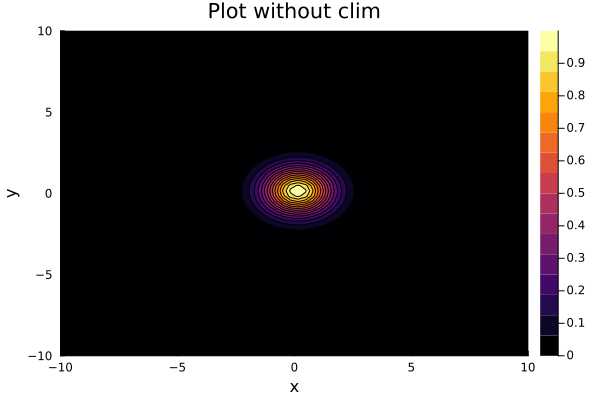

In [4]:
plot_mps(u[1], R, 6, xmin, xmax, ymin, ymax)